# Text classification with recurrent neural networks

Recurrent neural networks (RNNs) are appropriate for handling sequential data, where each point depends on the previous one(s). This is the case, e.g., for time series (audio/speech signals, financial data...), but also videos (time sequence of images), or text, which we consider here.
 
In this lab, we use RNNs for a binary classification task, which is hate speech detection from tweets. We introduce the global pipeline for preprocessing text data, as well as the basics of RNNs, and we implement a simple classification model.

**Note**: The first time you run this notebook, please uncomment the first cell below to download NLP pipelines (for English and German) using spacy.

In [1]:
# !python3 -m spacy download en_core_web_sm --quiet
# !python3 -m spacy download de_core_news_sm --quiet

In [2]:
! pip install torchtext --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
import copy
import matplotlib.pyplot as plt
import datasets
import spacy
import torchtext
from torchtext.vocab import build_vocab_from_iterator

In [4]:
# Main dataset path - If needed, you can change it HERE but NOWHERE ELSE in the notebook!
data_dir = '../datasets/'

### Dataset

We use the [Tweets Hate Speech](https://huggingface.co/datasets/tweets-hate-speech-detection/tweets_hate_speech_detection) dataset, which contains a collections of tweets, along with a label (0= no hate speech; 1=hate speech). It can be directly downloaded via the `datasets` package.

In [5]:
# Load (eventually download) the dataset
dataset = datasets.load_dataset("tweets-hate-speech-detection/tweets_hate_speech_detection", cache_dir=data_dir)["train"]
print(f"Dataset size: {len(dataset)}")

# Print one example: it has two keys 'tweet' and 'label', corresponding to the text and corresponding label
print(dataset[0])

Dataset size: 31962
{'label': 0, 'tweet': '@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'}


## Preprocessing text data

### Tokenizers

The first step to prepare our data is to define *tokenizers*, that is, how a string is transformed into a sequence of words (or *tokens*). For instance, "Welcome to the U.S.A.!" should be transformed into \["Welcome", "to", "the", "U.S.A.", "!"\]. These are called tokens in the general case because "!" is not a word.

To perform tokenization, we rely on language-specific rules, in order to preserve some particular structure: for instance, with a naïve approach, "U.S.A." would be split into 6 tokens \["U", ".", "S', ".", "A", "."\], but we want to consider it as a single token.

In [6]:
# load the English specific NLP pipeline
en_nlp = spacy.load('en_core_web_sm')

# define English tokenizer
def tokenize_en(text):
    return [tok.text for tok in en_nlp.tokenizer(text)]

# check on an example
print('Welcome to the U.S.A!')
print(tokenize_en('Welcome to the U.S.A.!'))

Welcome to the U.S.A!
['Welcome', 'to', 'the', 'U.S.A.', '!']


In [7]:
# a more complete function that also remove caps,and add special tokens corresponding to the start/end of a sentence
def tokenize_example(example, en_nlp, lower=True, sos_token='<sos>', eos_token='<eos>'):
    tokens = [token.text for token in en_nlp.tokenizer(example["tweet"])]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    return {"tokens": tokens}

sos_token = "<sos>"
eos_token = "<eos>"
print(tokenize_example(dataset[0], en_nlp, sos_token, eos_token))

{'tokens': ['<eos>', '@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '  ', '#', 'run', '<eos>']}


In [8]:
# Tokenize the whole dataset (it will add a 'tokens' entry to each data sample)
dataset = dataset.map(tokenize_example, fn_kwargs={"en_nlp": en_nlp})

### Vocabulary

Next, we need to build a *vocabulary* for the  language. A vocabulary associates each token to an integer index (e.g., "Welcome"=0, "to"=1, "the"=2, etc.) which then allows to manipulate text data with neural networks (since these can only operate on numerical data, not on strings/characters).


In [9]:
# We need to add special tokens for unknown words, and padding (when building batches of sentences with different lengths)
unk_token = "<unk>"
pad_token = "<pad>"
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

# Define the minimum frequency of occurence in the dataset
min_freq = 2

# The vocabulary is simply built using torchtext's 'build_vocab_from_iterator' method
en_vocab = build_vocab_from_iterator(
    dataset["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

Now that our vocabulary is build, there are a bunch of method to analyze it easily.

We can use the `vocab.itos` method to convert indices to the corresponding tokens (`itos` stands for "index to string"). The first tokens are the specified special tokens (here: `<unk>`, `<pad>`, `<sos>`, `<eos>`). Then the tokens are ranked by frequency of appearence in the dataset.

We can do the other way around (get the index from a token) using the `vocab.stoi()[tok]`, or directly `vocab[tok]`.

There are also lookup methods for processing list of indices / tokens.

In [10]:
print('Number of tokens in the vocabulary:', len(en_vocab))

print('First tokens in the vocabulary:', en_vocab.get_itos()[:15])

print(en_vocab.get_stoi()['to'])
print(en_vocab['to'])

Number of tokens in the vocabulary: 16467
First tokens in the vocabulary: ['<unk>', '<pad>', '<sos>', '<eos>', '#', '  ', '@user', ' ', '!', '.', 'the', 'to', 'i', 'a', ',']
11
11


In [11]:
# Operate on lists of tokens / indices with the lookup methods
print(en_vocab.lookup_indices(['dark', 'scoopwhoopnews', 'needed', 'london']))
print(en_vocab.lookup_tokens([976, 9868, 987, 428]))

[976, 9868, 987, 428]
['dark', 'scoopwhoopnews', 'needed', 'london']


If we try to get the index of a token that is not in the vocabulary, by default we will get an error. We need to specify explicitly a default index that will be returned when prompted an out-of-vocabulary word. Here, an appropriate choice is the token `<unk>`, whose index is 0.

In [12]:
# Set the default index at 0 (which corresponds to the <unk> token) for out-of-vocabulary tokens
en_vocab.set_default_index(0)
print(en_vocab['notinthevocabulary'])

0


### Numericalization

We can now perform numericalization, which is the process of transforming each tokenized sentence in the dataset into a list of indices. As a result, we now have a dataset of fully numerical data.

In [13]:
def numericalize_example(example, en_vocab):
    en_ids = en_vocab.lookup_indices(example["tokens"])
    return {"en_ids": en_ids}

print(numericalize_example(dataset[0], en_vocab))

{'en_ids': [2, 6, 55, 13, 102, 20, 0, 17, 20, 38, 3620, 99, 7024, 121, 291, 290, 121, 8749, 9, 5, 4, 511, 3]}


In [14]:
# Numericalize the whole dataset (it will add a 'en_ids' entry to each data sample)
dataset = dataset.map(numericalize_example, fn_kwargs={"en_vocab": en_vocab})

In [15]:
# We also need to convert 'en_ids' to torch tensors (as they are currently integers)
dataset = dataset.with_format(type="torch", columns=["en_ids"], output_all_columns=True)

### Dealing with an imbalanced dataset

In [16]:
# TO DO: Compute and display the proportion of positive samples in the dataset (= samples whose label is 1)

positive_samples = sum([1 for sample in dataset if sample['label'] == 1])
print(f"Proportion of positive samples: {positive_samples / len(dataset)}")


Proportion of positive samples: 0.07014579813528565


As computed above, there are roughly 7% tweets containing hate speech (label=1) and 93% tweets that do not contain hate speech (label=0). Such a dataset is said to be *imbalanced*, thus we cannot use it as such, otherwise it will cause issues at training and inference. Indeed, a naive approach where the network would set all outputs at 0 would yield a 93% accuracy, but would be completely useless in practice. A simple way to address this issue is to take a subset of the dataset, such that both classes are equally represented.

<span style="color:red">**Exercice 1**</span> Get a balanced subset of the dataset
- Get the list of indices of samples whose label is 0 (=`ind_pos`) and 1 (=`ind_neg`)
- Take the first 500 positive indices, and the same negative indices
- Take a subset of the dataset corresponding to these indices (use the `Subset` function), yielding `dataset_balanced`.

In [17]:
# Get the indices of positive and negative samples
ind_positive = list(filter(lambda i: dataset[i]['label'] == 1, range(len(dataset))))
ind_negative = list(filter(lambda i: dataset[i]['label'] == 0, range(len(dataset))))

# Take the first 500 positive indices, and the same number of negative indices
ind_positive = ind_positive[:500]
ind_negative = ind_negative[:500]

# Combine the positive and negative indices
balanced_indices = ind_positive + ind_negative

# Create a balanced subset of the dataset
dataset_balanced = Subset(dataset, balanced_indices)



In [18]:
# Split into training, validation, and test subsets
train_data, valid_data, test_data = random_split(dataset_balanced, [800, 100, 100], generator=torch.manual_seed(0))

In [19]:
# TO DO: Display the proportion of positive samples in the train, validation, and test sets
positive_samples_train = sum([1 for sample in train_data if sample['label'] == 1])
positive_samples_valid = sum([1 for sample in valid_data if sample['label'] == 1])
positive_samples_test = sum([1 for sample in test_data if sample['label'] == 1])

print(f"Proportion of positive samples in the training set: {positive_samples_train / len(train_data)}")

print(f"Proportion of positive samples in the validation set: {positive_samples_valid / len(valid_data)}")

print(f"Proportion of positive samples in the test set: {positive_samples_test / len(test_data)}")


Proportion of positive samples in the training set: 0.5075
Proportion of positive samples in the validation set: 0.46
Proportion of positive samples in the test set: 0.48


### Dataloader

The final step is to build a `Dataloader` to assemble our data samples into batches. Since data samples are sentences of different lengths in general, there is some *padding* needed to assemble them into consistent batches. As a result, we need to define a specific *collate function* for the dataloader (=i.e., the way data samples are assembled into batches - remember lab 1), that will handle this padding. For simplicity, we provide the collate function.

In [20]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_labels = [torch.tensor([example["label"]]) for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_labels = nn.utils.rnn.pad_sequence(batch_labels, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "labels": batch_labels
        }
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, shuffle=False, pad_index=1, seed=0):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        generator=torch.manual_seed(seed)
    )
    return data_loader

# Build dataloaders
batch_size = 32
train_data_loader = get_data_loader(train_data, batch_size, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size)
test_data_loader = get_data_loader(test_data, batch_size)

In [21]:
example_batch = next(iter(train_data_loader))
print(example_batch)

{'en_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   6,    6,    6,  ...,   12, 1530,    4],
        [   6,   23,   12,  ...,   76,  792,  389],
        ...,
        [   1,    1,  977,  ...,    1,    1,    1],
        [   1,    1,    8,  ...,    1,    1,    1],
        [   1,    1,    3,  ...,    1,    1,    1]]), 'labels': tensor([[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 1, 0, 1, 1]])}


## Recurrent networks basics

Now that our data is ready, let's see the basic operations used in RNNs: [embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding), [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), and [recurrent layers](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

### Embedding layer

Sentences have been tokenized and tokens have been transformed into integers, depending on their frequency of occurence in the corpus. Therefore, two consecutive integers correspond to tokens that are not necessarily *similar* from a semantic perspective.

For instance, the token "dog" is represented by integer 277. While similar tokens might be spraid away (here: animals such as "cat" and "duck" are represented by integers 518 and 3774), the surrounding integers 276 and 278 correspond to un-related tokens ("polar" and "before"). In other words: integers that are close to each other do not correspond to tokens that are similar. This is a problem for NLP applications, where the numerical representation of the data should incorporate this notion of *similarity*.

One way to overcome this issue it to further transform these integers into high-dimensional *embeddings* (or *word vectors*), that will be trained in such a way that similar tokens should have similar embeddings.

<center><a href="https://ruder.io/word-embeddings-1/">
    <img src="https://ruder.io/content/images/size/w2000/2016/04/word_embeddings_colah.png" width="500"></a></center>

Since it's hard to define exactly what *similar* means out of context, embeddings are usually learned / optimized for a certain task. Here, we use an embedding layer to produce these word vectors, and this layer is learned during training along with the rest of the network.

**Note**: many pre-trained word embeddings are available (e.g., word2vec) and could be loaded directly. Here, we learn them from scratch for simplicity.

In [22]:
# Create an embedding layer. We need to specify:
# - the input size, that is, how many words are in the vocabulary
# - the embedding size, that is, how "big" is the word vectors space
input_size = len(en_vocab)
emb_size = 32
src_emb_layer = nn.Embedding(input_size, emb_size)

# Apply it to the example batch and display it
embedded_batch = src_emb_layer(example_batch['en_ids'])
print(embedded_batch)

# The size of the word vectors for a batch should be [seq_length, batch_size, emb_size]
print(embedded_batch.shape)

tensor([[[-0.8108, -1.1052, -0.7233,  ...,  1.6909, -0.4622,  0.4427],
         [-0.8108, -1.1052, -0.7233,  ...,  1.6909, -0.4622,  0.4427],
         [-0.8108, -1.1052, -0.7233,  ...,  1.6909, -0.4622,  0.4427],
         ...,
         [-0.8108, -1.1052, -0.7233,  ...,  1.6909, -0.4622,  0.4427],
         [-0.8108, -1.1052, -0.7233,  ...,  1.6909, -0.4622,  0.4427],
         [-0.8108, -1.1052, -0.7233,  ...,  1.6909, -0.4622,  0.4427]],

        [[ 0.7012, -1.9098,  1.0538,  ...,  1.0826, -1.7105,  0.5070],
         [ 0.7012, -1.9098,  1.0538,  ...,  1.0826, -1.7105,  0.5070],
         [ 0.7012, -1.9098,  1.0538,  ...,  1.0826, -1.7105,  0.5070],
         ...,
         [ 0.3728, -1.0211,  1.0795,  ...,  0.1333,  0.1249, -1.0770],
         [ 0.6276,  0.3513, -2.2446,  ..., -0.5044,  0.5849,  0.7775],
         [ 1.2868,  2.0820,  0.1167,  ..., -0.5711, -0.1195,  0.3416]],

        [[ 0.7012, -1.9098,  1.0538,  ...,  1.0826, -1.7105,  0.5070],
         [ 1.1734, -1.5961,  0.8083,  ...,  0

### Dropout

The core idea of a dropout layer is to reduce the risk of overfitting by randomly setting some inputed values at 0. Since the non-zero inputs (and the corresponding weights in the network) are not the same from one batch to another, it results in forcing these weights not to be batch-specific, and therefore avoid overfitting. Dropout can be used for any network (including MLP or CNNs), but it's more important for RNNs, which are more prone to overfitting.

In [23]:
# the percentage of zeroed values (expressed between 0 and 1) is given as input
dropout_layer = nn.Dropout(0.3)
drop_batch = dropout_layer(embedded_batch)

# in this example, about 30% are set at 0
print(torch.sum(drop_batch==0) / torch.numel(drop_batch) )

tensor(0.2997)


### Recurrent layers

<center><a href="https://www.researchgate.net/profile/Rezzy-Caraka/publication/346410173_Employing_Long_Short-Term_Memory_and_Facebook_Prophet_Model_in_Air_Temperature_Forecasting/links/60077104a6fdccdcb868957f/Employing-Long-Short-Term-Memory-and-Facebook-Prophet-Model-in-Air-Temperature-Forecasting.pdf">
    <img src="https://www.researchgate.net/profile/Rezzy-Caraka/publication/346410173/figure/fig2/AS:962598073823234@1606512673418/Network-Structure-of-RNN-LSTM-and-GRU.png" width="500"></a></center>

We now see the 3 main recurrent layers (simple RNN, LSTM and GRU). We won't focus on the technical difference between these, but you can find more info online (e.g., [here](https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573)).

#### Simple RNN

First, let's see the basic RNN. We note $x_t$ the $t$-th element of the input to the RNN (in our case: this is the embedding after dropout). We have $h_t = \text{RNN}(x_t, h_{t-1})$, where $h_{t}$ is the hidden state. To define such an RNN in Pytorch (using ```nn.RNN```), you need to specify:

- the size of the input (here, it's the size of the embeddings)
- the size of the hidden space (`hidden_size`)
- the number of layers (`n_layers`)

By default, the RNN is uni-directional, uses bias, and uses tanh as activation function. If you use a multi-layer RNN, you can also add dropout in the intermediate layers. You can change these by playing with the parameters of the function (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) for more info).

**Note**: for the first element of the sequence, we have $h_1 = \text{RNN}(x_1, h_{0})$, so we normally need to provide an initial hidden state $h_0$. In pytorch, we can either provide it explicitly or not. If we don't, it will use $h_0=0$ by default. This is what we do here, and it also applies to other recurrent units (LSTM and GRU).

In Pytorch, applying an RNN returns not one, but two outputs, usually called `out` and `hidden`, illustrated below:

- `out` is the whole sequence of hidden states of the last layer,
- `hidden` is the hidden state of the last token for all layers, which is also called a **context vector**, since it is sort of a summary of the whole sentence.

<center><img src="https://github.com/magronp/magronp.github.io/blob/master/images/rnn_outputs.png?raw=true" width="500"></center>

In [24]:
# Define a basic RNN
hidden_size = 50
n_layers = 2
rnn = nn.RNN(emb_size, hidden_size, n_layers)

# Apply the RNN to the input (embeddings after dropout, called 'drop_batch')
rnn_out, rnn_hidden = rnn(drop_batch)

# Get the size of the 'rnn_out': it should be [seq_length, batch_size, hidden_size]
print(rnn_out.shape)

# Get the size of the'rnn_hidden': it should be [n_layers, batch_size, hidden_size]
print(rnn_hidden.shape)

torch.Size([34, 32, 50])
torch.Size([2, 32, 50])


In [25]:
# TO DO:
# - create a 3-layer bidirectional RNN (remember to check the documentation!)
# - apply it to the same input 'embedded_batch'

hidden_size = 50
n_layers = 3
rnn = nn.RNN(emb_size, hidden_size, n_layers, bidirectional=True)

rnn_out, rnn_hidden = rnn(drop_batch)

# Print the size of rnn_out (it should be [seq_length, batch_size, 2*hidden_size])
# Print the size of the final hidden state (it should be [2*n_layers, batch_size, hidden_size])
# (the factor '2' in the shapes comes from the fact that the network is bidirectional)

print(rnn_out.shape)
print(rnn_hidden.shape)

torch.Size([34, 32, 100])
torch.Size([6, 32, 50])


Note that all recurrent layers can also use dropout to randomly remove some of the inner RNN weights. This only makes sense if `n_layers` > 1, otherwise you'll get a warning.

#### LSTM

The basic RNN suffers from the gradient vanishing problem, so we will instead use a variant of it called *long short-term memory* (LSTM) networks. The key idea of LSTM is that it has an extra hidden feature called a *cell state* which allows the network to "remember" which part of the input sequence is useful or not, and therefore to avoid backpropagating the gradient throughout the whole sequence, thus avoiding gradient vanishing.

The formula for the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) is therefore: $(h_t, c_t) = \text{LSTM}(x_t, h_{t-1}, c_{t-1})$ where $c_t$ is this extra cell state.

In [26]:
# Define an LSTM
hidden_size = 50
n_layers = 2
lstm = nn.LSTM(emb_size, hidden_size, n_layers, bidirectional=True)

# Apply the LSTM to the embedded batch
lstm_out, (lstm_hidden, lstm_cell) = lstm(embedded_batch)

# The shape of the output and final hidden state are the same as before.
# The final cell state as the same size as the final hidden state.
print(lstm_out.shape)
print(lstm_hidden.shape)
print(lstm_cell.shape)

torch.Size([34, 32, 100])
torch.Size([4, 32, 50])
torch.Size([4, 32, 50])


#### GRU

The last main type of recurrent layer is the gated reccurent unit (GRU). It is sort of a simplified LSTM: it also has some memory mechanism to avoid gradient vanishing, but it outputs only a single hidden state vector (instead of the additional cell state in LSTM). It generally performs similarly with LSTM (but this depends on applications). Writting a [GRU in pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU) is similar to a basic RNN.

In [27]:
# TO DO: using the doc, write a GRU layer with a hidden size of 50 and 2 layers.
# Apply it to the embedded batch as before, and print the size of the output and final hidden state.

hidden_size = 50
n_layers = 2

gru = nn.GRU(emb_size, hidden_size, n_layers, bidirectional=True)
gru_out, gru_hidden = gru(embedded_batch)

print(gru_out.shape)
print(gru_hidden.shape)


torch.Size([34, 32, 100])
torch.Size([4, 32, 50])


<span style="color:red">**Exercice 2**</span> Display the number of parameters of a monodirectional RNN, GRU, and LSTM network with `hidden_size=32` and `n_layers=2` (same `emb_size` as before).

In [28]:
hidden_size = 32
n_layers = 2

# Definne mono-directional RNN
rnn = nn.RNN(emb_size, hidden_size, n_layers, bidirectional=False)

# Display the number of parameters
print(f"Number of parameters in the RNN: {sum(p.numel() for p in rnn.parameters())}")



Number of parameters in the RNN: 4224


In [29]:
# Define mono-directional GRU
gru = nn.GRU(emb_size, hidden_size, n_layers, bidirectional=False)

# Display the number of parameters
print(f"Number of parameters in the GRU: {sum(p.numel() for p in gru.parameters())}")

Number of parameters in the GRU: 12672


In [30]:
# Define mono-directional LSTM
lstm = nn.LSTM(emb_size, hidden_size, n_layers, bidirectional=False)

# Display the number of parameters
print(f"Number of parameters in the LSTM: {sum(p.numel() for p in lstm.parameters())}")

Number of parameters in the LSTM: 16896


## Building the classifier

We now have all the basic blocks to build our text classification model. 

<center><a href="https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=fr">
    <img src="https://www.tensorflow.org/text/tutorials/images/bidirectional.png?hl=fr"></a></center>

Since the data is already vectorized, the model consists of:

- an embedding layer (+ dropout, eventually) to transform token indices into word vectors,
- a bidirectional RNN, to summarize the whole sentence into a single context vector,
- a linear layer, to compute the class probability from the context vector (followed by a Sigmoid, to ensure probabilities range between 0 and 1).

**Note**: A few remarks can be made for the specific case of *binary* classification vs. more general classification tasks with an arbitrary number of classes (as we have seen until now).

- While for general classifiers the output has shape `[batch_size, num_classes]`, for binary classification the model does not need to output `[batch_size, 2]`. Indeed, the linear layer simply outputs a single probability $p$ (for each element in the batch) corresponding to label 1, since the probability corresponding to label 0 is fully determined by $1-p$. Thus the output has shape `[batch_size, 1]`.

- As for general classifiers, the output does not need to be explicitly normalized as a probability in \[0,1\] (which could be done with, e.g., a Sigmoid). General classifiers are trained with the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss) function, which incorporates such a normalization. The same applies to binary classifiers: these are usually trained with the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss) function, which incorporates a Sigmoid activation function.

In [31]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout_rate, bidir=True):
        super(RNNClassifier, self).__init__()

        # Create the embedding, dropout, RNN, and linear layers
        self.embedding = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.rnn = nn.RNN(emb_size, hidden_size, n_layers, bidirectional=bidir)
        self.linear = nn.Linear(hidden_size * 2, 1)

    def forward(self, src):

        # Compute the embeddings
        embeddings = self.embedding(src)
        embeddings = self.dropout(embeddings)

        # Apply the RNN to get the last hidden state 'hidden'
        rnn_out, hidden = self.rnn(embeddings)

        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        # Apply the linear layer
        out = self.linear(hidden)

        return out

In [32]:
# Network parameters
input_size = len(en_vocab)
emb_size_enc = 32
hidden_size = 32
n_layers = 2
dropout_rate = 0.2

In [33]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
    elif isinstance(m, nn.RNN) or isinstance(m, nn.GRU) or isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data, generator=torch.manual_seed(seed))
            else:
                nn.init.normal_(param.data, generator=torch.manual_seed(seed))
    return

<span style="color:red">**Exercice 3**</span> Instanciate the classifier, and print the number of trainable parameters. Then, pass the `example_batch` to the model, and print the size of the output `out`.

In [34]:
model = RNNClassifier(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)

model.apply(init_params)

print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

out = model(example_batch['en_ids'])
print(out.shape)

Number of parameters in the model: 537505
torch.Size([32, 1])


**Note**: If you display `out` and compute it again, you should obtain a different result! This is due to the dropout that performs some random operations. This is why it is important to disable dropout when evaluating the model (via `model.eval()`)

In [35]:
# Get different values because of dropout
print(out[0])
out = model(example_batch['en_ids'])
print(out[0])

# If the model is in eval mode, then the output stays the same
out = model(example_batch['en_ids'])
print(out[0])
out = model(example_batch['en_ids'])
print(out[0])

tensor([-2.5805], grad_fn=<SelectBackward0>)
tensor([-2.5820], grad_fn=<SelectBackward0>)
tensor([-2.5810], grad_fn=<SelectBackward0>)
tensor([-2.5816], grad_fn=<SelectBackward0>)


## Training and evaluation

We provide the training and evaluation functions, since these are the same as for the classifiers we have seen before.

In [36]:
def evaluate_rnnclassif(model, eval_dataloader):

    # Set the model in 'eval' mode (disable dropout layer)
    model.eval()
    
    # Initialize the eval loss
    eval_loss = 0

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # loop over batches
        for i, batch in enumerate(eval_dataloader):

            # Get the text and true label
            x, labels = batch['en_ids'], batch['labels']
            labels = labels.to(torch.float32).T

            # Apply the model and get the labels by thresholding
            label_predicted = model(x)
            #label_predicted = label_predicted > 0.5 # if the model outputs a probability (training with BCELoss)
            label_predicted = label_predicted > 0 # if the model outputs a logit (training with BCEWithLogitsLoss)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [37]:
def training_rnnclassif(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # define the optimizer (Adam)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize lists for storing the training and validation losses over epochs
    train_losses = []
    val_accuracies = []
    
    # Initialize the optimal validation accuracy at 0
    val_acc_opt = 0

    for epoch in range(num_epochs):
        tr_loss = 0

        # Set the model in 'training' mode (ensures all parameters' gradients are computed)
        model_tr.train()

        for i, batch in enumerate(train_dataloader):

            print("Batch size: ", batch['en_ids'].shape)

            # Get the source and target sentence, and the target sentence length (varies from batch to batch)
            x, labels = batch['en_ids'], batch['labels']
            labels = labels.to(torch.float32).T

            # Set the gradients at 0
            optimizer.zero_grad()

            # Apply the model
            pred_labels = model_tr(x)

            print(pred_labels.shape, labels.shape)
            # Backpropagation
            loss = loss_fn(pred_labels, labels)
            loss.backward()
            optimizer.step()

            # Update the current epoch loss
            tr_loss += loss.item()
            
        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader)
        train_losses.append(tr_loss)

        # Compute the accuracy on the validation set and store it
        val_acc = evaluate_rnnclassif(model_tr, valid_dataloader)
        val_accuracies.append(val_acc)
        
        # Display the training loss and validation accuracy
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f} ; Validation accuracy: {:.4f}'
                  .format(epoch+1, num_epochs, tr_loss, val_acc))

        # Record the model if the validation accuracy is higher than the "optimal" value
        if val_acc > val_acc_opt:
            model_opt = copy.deepcopy(model_tr)
            val_acc_opt = val_acc
            
    return model_opt, train_losses, val_accuracies

In [38]:
# Training parameters
learning_rate = 0.001
num_epochs = 30

# We use the binary cross entropy (with logits) as loss function
loss_fn = nn.BCEWithLogitsLoss()

# Re-instanciate a classifier and initialize its parameters
model = RNNClassifier(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
model.apply(init_params)

RNNClassifier(
  (embedding): Embedding(16467, 32)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): RNN(32, 32, num_layers=2, bidirectional=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

Batch size:  torch.Size([37, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([34, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([29, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([39, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([38, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([31, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([36, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([41, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([30, 32])
torc

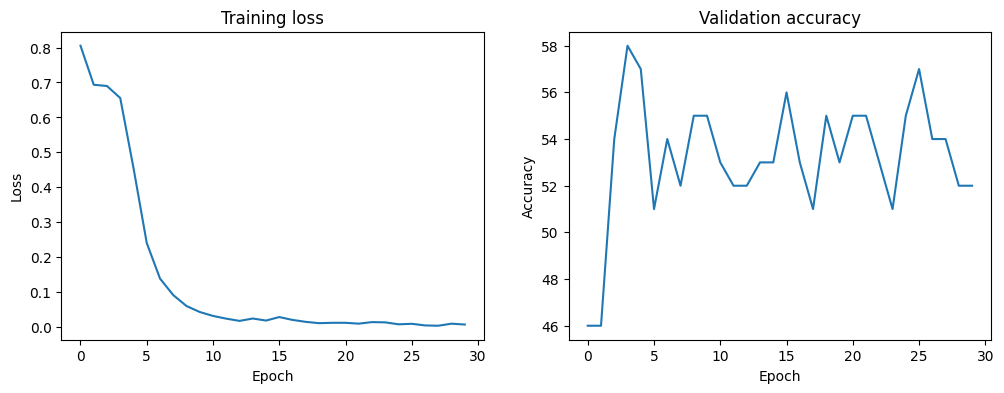

In [39]:
# TO DO: train the model, and plot the training loss and validation accuracy (on two different subplots)
model, train_losses, val_accuracies = training_rnnclassif(model, train_data_loader, valid_data_loader, num_epochs, loss_fn, learning_rate)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()



In [40]:
# TO DO: Compute the accuracy on the test set
accuracy = evaluate_rnnclassif(model, test_data_loader)
print(f"Accuracy on the test set: {accuracy:.2f}%")


Accuracy on the test set: 60.00%


## Alternative networks

You can see that the basic RNN above does not yield a great performance (it's roughly the same as random classification). One possible reason is the [vanishing gradient](https://www.baeldung.com/cs/lstm-vanishing-gradient-prevention) problem. To alleviate this issue, instead of the basic RNN we test the gated variants of recurrent networks (GRU and LSTM).

To that end, we write a `GeneralClassifier` class that is very similar to the `RNNClassifier`, but it takes an additional input argument `net_type` that can be `'rnn'`, `'gru'`, or `'lstm'`. Remember that unlike the basic RNN and GRU, the LSTM outputs an additional cell state, so be careful when implementing the `forward` pass (here the classifier only uses the hidden state, so the cell state can be discarded).

In [41]:
# TO DO: write the GeneralClassifier class described above
class GeneralClassifier(nn.Module):
  def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout_rate, bidir=True, net_type='lstm'):
    super(GeneralClassifier, self).__init__()

    self.net_type = net_type
    # Create the embedding, dropout, RNN, and linear layers
    self.embedding = nn.Embedding(input_size, emb_size)
    self.dropout = nn.Dropout(dropout_rate)
    if net_type == 'rnn':
      self.rnn = nn.RNN(emb_size, hidden_size, n_layers, bidirectional=bidir)
    elif net_type == 'gru':
      self.rnn = nn.GRU(emb_size, hidden_size, n_layers, bidirectional=bidir)
    elif net_type == 'lstm':
      self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, bidirectional=bidir)

    self.linear = nn.Linear(hidden_size * 2, 1)

  def forward(self, src):

      # Compute the embeddings
      embeddings = self.embedding(src)
      embeddings = self.dropout(embeddings)
  
      if self.net_type == 'lstm':
        rnn_out, (hidden, cell) = self.rnn(embeddings)
      else:
        rnn_out, hidden = self.rnn(embeddings)
  
      hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
  
      # Apply the linear layer
      out = self.linear(hidden)
  
      return out


<span style="color:red">**Exercice 4**</span> For each network type (RNN, GRU, LSTM), instanciate and initialize the model, print the number of parameters, train it, and compute the test accuracy. Which one do you recommend to use?

In [42]:
# RNN model
model_rnn = GeneralClassifier(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate, net_type='rnn')
model_rnn.apply(init_params)

print(f"Number of parameters in the RNN model: {sum(p.numel() for p in model_rnn.parameters() if p.requires_grad)}")

# Training
model_rnn, train_losses_rnn, val_accuracies_rnn = training_rnnclassif(model_rnn, train_data_loader, valid_data_loader, num_epochs, loss_fn, learning_rate)

# Compute the accuracy on the test set

accuracy_rnn = evaluate_rnnclassif(model_rnn, test_data_loader)
print(f"Accuracy on the test set (RNN): {accuracy_rnn:.2f}%")


Number of parameters in the RNN model: 537505
Batch size:  torch.Size([37, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([34, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([29, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([39, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([38, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([31, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([36, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([41, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([

In [43]:
#GRU model
model_gru = GeneralClassifier(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate, net_type='gru')
model_gru.apply(init_params)

print(f"Number of parameters in the GRU model: {sum(p.numel() for p in model_gru.parameters() if p.requires_grad)}")

# Training
model_gru, train_losses_gru, val_accuracies_gru = training_rnnclassif(model_gru, train_data_loader, valid_data_loader, num_epochs, loss_fn, learning_rate)

# Compute the accuracy on the test set
accuracy_gru = evaluate_rnnclassif(model_gru, test_data_loader)

print(f"Accuracy on the test set (GRU): {accuracy_gru:.2f}%")

Number of parameters in the GRU model: 558497
Batch size:  torch.Size([37, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([34, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([29, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([39, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([38, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([31, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([36, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([41, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([

In [44]:
# LSTM model
model_lstm = GeneralClassifier(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate, net_type='lstm')
model_lstm.apply(init_params)

print(f"Number of parameters in the LSTM model: {sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)}")

# Training
model_lstm, train_losses_lstm, val_accuracies_lstm = training_rnnclassif(model_lstm, train_data_loader, valid_data_loader, num_epochs, loss_fn, learning_rate)

# Compute the accuracy on the test set
accuracy_lstm = evaluate_rnnclassif(model_lstm, test_data_loader)

print(f"Accuracy on the test set (LSTM): {accuracy_lstm:.2f}%")

Number of parameters in the LSTM model: 568993
Batch size:  torch.Size([37, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([34, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([29, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([39, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([38, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([31, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([36, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([33, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([41, 32])
torch.Size([32, 1]) torch.Size([32, 1])
Batch size:  torch.Size([32, 32])
torch.Size([32, 1]) torch.Size(

In [46]:
## Comment on the results: I will recommend to use the GRU model as it has the highest accuracy on the test set, 80%.
# The LSTM model is a close second with 78% accuracy, and the RNN model has the lowest accuracy of 60%.